In [4]:
import cv2
import os,sys,random
import numpy as np
import gzip
import time,tqdm
import matplotlib.pyplot as plt

## logistic regression

In [115]:
epsilon = 0.0000001

def linear_model(X, W, b):
    return np.matmul(X, W) + b


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def logistic_model(X, W, b):
    return sigmoid(linear_model(X,W,b))


def logistic_regression_cost_function(h,y):
    return 1/y.shape[0] * (-y.T * np.log(h + epsilon) - (1 - y.T) * np.log(1- h + epsilon))


def gradient_descent_update(X, y, h, W, b, alpha = 0.01):
    m = X.shape[0]
    d_W = (X.T * (h - y)) / m
    d_b = np.mean(h - y)
    return (W - alpha * d_W), (b - alpha * d_b)


def feature_normalize(X,stds,means):
    for c in range(X.shape[1]):
        X[:, c] = (X[:, c] - means[0,c]) / stds[0,c]
    return X


def prepare_data(X,y):
    X = np.mat(X.reshape((X.shape[0], X.shape[1] * X.shape[2])),dtype=np.float32)
    y = np.mat(y,dtype=np.float32)
    return X,y


def binary_confusion_matrix(h, y, threshold=0.5):
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for cid in range(0, y.shape[0]):
        if h[cid] > threshold:            
            if y[cid] > 0.5:
                true_pos += 1
            else:
                false_pos += 1
        else:
            if y[cid] > 0.5:
                false_neg += 1
            else:
                true_neg += 1
    pc = true_pos / (true_pos + false_pos)
    rc = true_pos / (true_pos + false_neg)
    f1 = 2.0 * (pc * rc) / (pc + rc)
    return pc, rc, f1

def predict(h,y,threshold=0.5):
    count = 0
    for i in range(y.shape[0]):
        result = 0
        if h[i] > threshold:
            result = 1
        if y[i] == result:
            count += 1
    return count


def showcase(X, y, h, case_num=10):
    for test_i in range(0, case_num):
        rid = random.randint(0, y.shape[0] - 1)
        img = np.reshape(X[rid],(30,30))
        show_img(img)
        print('truth: {0}, h: {1}'.format(alphabet_labels[np.argmax(y[rid])],  alphabet_labels[np.argmax(h[rid])]))

        
def show_img(img, zoom=4, dpi=80):
    w = img.shape[0]
    h = img.shape[1]
    plt.figure(figsize=(w*zoom/dpi, h*zoom/dpi), dpi=dpi)
    plt.axis('off')
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()
    return

shape X (100000, 30, 30), y (100000, 26)
shape X (20000, 30, 30), y (20000, 26)
shape X (10000, 30, 30), y (10000, 26)
sample image:


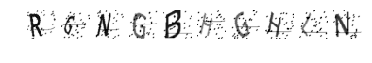

sample label: ['R', 'G', 'N', 'G', 'B', 'H', 'G', 'H', 'L', 'N']

training size: 100000


In [105]:
train_data = np.load('./data.npz')
train_X=train_data['X']
train_y=train_data['y']
print('shape X {0}, y {1}'.format(train_X.shape, train_y.shape))

validate_data = np.load('./val.npz')
validate_X=validate_data['X']
validate_y=validate_data['y']
print('shape X {0}, y {1}'.format(validate_X.shape, validate_y.shape))

test_data = np.load('./test.npz')
test_X=test_data['X']
test_y=test_data['y']
print('shape X {0}, y {1}'.format(test_X.shape, test_y.shape))


alphabet_labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
print('sample image:')
train_labels = []
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_X[i], cmap='Greys_r')
    plt.axis('off')
    train_labels.append(alphabet_labels[np.argmax(train_y[i])])
plt.show()
print('sample label: %s' % train_labels)
print('')
print('training size: %s' % len(train_X))

In [106]:
train_X,train_y = prepare_data(train_X,train_y)
validate_X,validate_y = prepare_data(validate_X,validate_y)
test_X,test_y = prepare_data(test_X,test_y)

# stds = np.std(train_X, axis=0)
# means = np.mean(train_X, axis=0)
# train_X = feature_normalize(train_X,stds,means)
# test_X = feature_normalize(test_X,stds,means)
# validate_X = feature_normalize(validate_X,stds,means)

train_X = (train_X/255).astype(np.float32)
test_X = (test_X/255).astype(np.float32)
validate_X = (validate_X/255).astype(np.float32)

train_X.shape

(100000, 900)

In [119]:
feature_count = train_X.shape[1];
all_W = np.mat(np.zeros((26,feature_count),dtype=np.float32))
all_b = np.mat(np.zeros((26,1),dtype=np.float32))

alpha = 0.01 # 太高时会出现 会直接跳过
iterations = 1000
threshold=0.5
step = 500

for c in range(26):
    W = np.array(np.random.randn(feature_count)).astype(np.float32).reshape(feature_count,1)
    b = np.random.randn()
    train_y_c = train_y[:,c:c+1]
    validate_y_c = validate_y[:,c:c+1]

    print("training :",alphabet_labels[c])
    for epoch in range(iterations):
        h = logistic_model(train_X,W,b)
        W,b = gradient_descent_update(train_X,train_y_c,h,W,b,alpha)
        if (epoch + 1) % step == 0:
            train_h = logistic_model(train_X,W,b)
            train_cost = logistic_regression_cost_function(h,train_y_c)
            val_h = logistic_model(validate_X,W,b)
            val_cost = logistic_regression_cost_function(val_h,validate_y_c)
            print("epoch: {0},the train cost:{1},the val cost:{2}".format(epoch + 1,train_cost,val_cost))
    
    train_h = logistic_model(train_X,W,b)
    train_cost = logistic_regression_cost_function(h,train_y_c)
    val_h = logistic_model(validate_X,W,b)
    val_cost = logistic_regression_cost_function(val_h,validate_y_c)
    cur_conf = binary_confusion_matrix(h, validate_y_c, threshold=threshold)  
    cur_count = predict(h,validate_y_c,threshold=threshold)
    print("finish train {0},the train cost:{1},the val cost:{2}".format(alphabet_labels[c],train_cost,val_cost))
    print("the validate {0},the accuracy:{1},the precision:{2},recall:{3},f1:{4}".format(alphabet_labels[c],cur_count/validate_X.shape[0],cur_conf[0],cur_conf[1],cur_conf[2]))
    all_W[c,:] = W.T
    all_b[c,:] = b

training : A
epoch: 500,the train cost:[[ 0.42856033]],the val cost:[[ 0.41541096]]
epoch: 1000,the train cost:[[ 0.40459304]],the val cost:[[ 0.39191223]]
finish train A,the train cost:[[ 0.40459304]],the val cost:[[ 0.39191223]]
the validate A,the accuracy:0.93725,the precision:0.05206463195691203,recall:0.03835978835978836,f1:0.044173648134044174
training : B
epoch: 500,the train cost:[[ 0.30096469]],the val cost:[[ 0.32119478]]
epoch: 1000,the train cost:[[ 0.29470109]],the val cost:[[ 0.31443611]]
finish train B,the train cost:[[ 0.29470109]],the val cost:[[ 0.31443611]]
the validate B,the accuracy:0.93565,the precision:0.05108055009823183,recall:0.03132530120481928,f1:0.038834951456310676
training : C
epoch: 500,the train cost:[[ 0.33690295]],the val cost:[[ 0.34450626]]
epoch: 1000,the train cost:[[ 0.31934406]],the val cost:[[ 0.32619826]]
finish train C,the train cost:[[ 0.31934406]],the val cost:[[ 0.32619826]]
the validate C,the accuracy:0.9359,the precision:0.04081632653061

epoch: 500,the train cost:[[ 0.39849326]],the val cost:[[ 0.44419239]]
epoch: 1000,the train cost:[[ 0.38610067]],the val cost:[[ 0.4302463]]
finish train Y,the train cost:[[ 0.38610067]],the val cost:[[ 0.4302463]]
the validate Y,the accuracy:0.93335,the precision:0.036328871892925434,recall:0.02240566037735849,f1:0.02771699489423778
training : Z
epoch: 500,the train cost:[[ 0.33897239]],the val cost:[[ 0.3307825]]
epoch: 1000,the train cost:[[ 0.32308724]],the val cost:[[ 0.31556938]]
finish train Z,the train cost:[[ 0.32308724]],the val cost:[[ 0.31556938]]
the validate Z,the accuracy:0.93925,the precision:0.038,recall:0.025232403718459494,f1:0.030327214684756583


In [336]:
predicts = np.mat(np.zeros((validate_X.shape[0],26),dtype=np.float32))
for i in range(26):
    predicts[:,i] = logistic_model(validate_X,all_W[i,:].T,all_b[i])

count = 0
for i in range(len(predicts)):
    a = np.array(predicts[i])
    max_index = np.argmax(predicts[i])
    if validate_y[i,max_index] == 1:
        count += 1
print("Accuracy : %f, the predict ture item: %d, the predict sum：%d" % (count/len(validate_X) * 100,count,len(validate_X)))

Accuracy : 78.025000, the predict ture item: 15605, the predict sum：20000


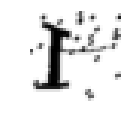

truth: I, h: A


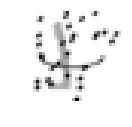

truth: J, h: A


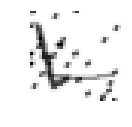

truth: L, h: A


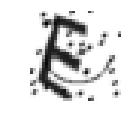

truth: E, h: A


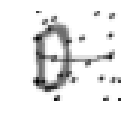

truth: D, h: A


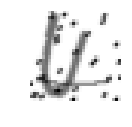

truth: U, h: A


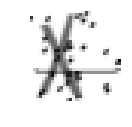

truth: X, h: A


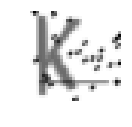

truth: K, h: A


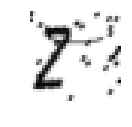

truth: Z, h: A


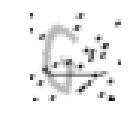

truth: G, h: A


In [116]:
h = np.mat(np.zeros((test_X.shape[0],26),dtype=np.float32))
for i in range(26):
    h[:,i] = logistic_model(test_X,all_W[i,:].T,all_b[i])

showcase(test_X * 255,test_y,h)

## neural network 

In [114]:
test_X[0].shape

(1, 900)